##**Welcome to the module 6a coding part: Loading and preparing Data!**

*This notebook was created at San Francisco State University (SFSU) for the Promoting INclusivity and Computing (PINC) and gSTAR programs by Dr. Pleuni Pennings (SFSU biology professor), Lucy Moctezuma Tan (California State University, East Bay CSUEB master student) and Lorena Benitez-Rivera (SFSU master students). All members of the COde to understand Drug resistance Evolution (CODE) lab in 2023.*

#OBJECTIVE OF THIS NOTEBOOK:

In this notebook we are going to load and prepare the antibiotic resistance data to use in the next notebook and reproduce the Moradigaravand 2018 paper machine learning models.

The main **goal** is to explore and undertand the data we will be using as features to predict **Resistance (R)** or **Susceptibility (S)** in *E.coli* bacteria for several drugs. In addition we will learn how to clean up and preprocess our data before feeding it into different machine learning algorythms.

This tutorial will use the features of:

*   **Year of isolation (Y)**
*   **Gene absence or presence (G)**
*   **Population Structure (S)**   

### ***Data origin***:
**Publication**:
Moradigaravand D, Palm M, Farewell A, Mustonen V, Warringer J, Parts L (2018) Prediction of antibiotic resistance in *Escherichia coli* from large-scale pan-genome data. PLoS Comput Biol 14(12): e1006258. https://doi.org/10.1371/journal.pcbi.1006258

**Github page**: https://github.com/DaneshMoradigaravand/PanPred


#WHY ANTIBIOTIC RESISTANCE?

Antibiotic resistance has become a global public health concern. Bacteria are evolving resistance to the current arsenal of prescribed antibiotics resulting in strains that are developing multi-drug resistance. Currently, doctors and clinics often perform traditional culture-based assays (i.e., testing whether a drug would kill the bacteria in a petri dish) to determine antibiotic resistance in bacterial strains.

Alternatively, clinics can also choose to sequence these strains. These sequences can then be analyzed in order to predict if it will show resistance to a certain drug. There are different ways to perform the analysis and machine learning is one of them. This series of tutorials intends to help students understand how to do such analysis.

We will process publically available whole genome sequences of *E. coli* strains to create:

1.   **Gradient Boosted Trees**
2.   **Random Forest**
3.   **Logistic Regression**

These three models are going to be used to predict **Resistance (R)** and **Susceptibility (S)** for each strain. The strains have already been tested in the lab, so we will later be able to compare the predictions made by our machine learning models with the traditional culture-based assays results in order to determine the performance for each of these models.

## **Step 1) Importing all necessary packages for dataframe manipulation**

The code below will allow you to import the packages needed to load  pre-process the data used for our models. In addition we will be loading up the **"os"** package, which will help us use the google drive much like how we create and save files in our own computer.

**NOTE:** Please allow access to your google drive when prompted, this will let you create and store the files in your drive to be accessed later by subsequent notebooks as we make progress towards getting our final results.

In [1]:
# Data Wrangling Imports
import pandas as pd
import numpy as np
from functools import reduce

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# File Manipulation Imports
import os as os
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## **Step 2) Loading all feature datasets used for predictions**

The features from the paper we will use for this workshop are:

**a) Metadata**: Year of isolation and results from Antimicrobial Susceptibility Testing.

**b) Gene presence and absence**: Coding regions converted to proteins and ortholog accessory genes.

**c) Population structure**: Clusters based on SNPs distance (number of differing sites) for core genome.

In [2]:
# assign to url variable for each csv file
metadata_url = 'https://raw.githubusercontent.com/DaneshMoradigaravand/PanPred/master/test_data/Metadata.csv'
gene_presence_url = 'https://raw.githubusercontent.com/DaneshMoradigaravand/PanPred/master/test_data/AccessoryGene.csv'
pop_struc_url = 'https://raw.githubusercontent.com/DaneshMoradigaravand/PanPred/master/test_data/PopulationStructure.csv_labelencoded.csv'

# load csv files into the notebook
metadata = pd.read_csv(metadata_url)
gene_presence_data = pd.read_csv(gene_presence_url)
pop_struc_data = pd.read_csv(pop_struc_url)

### **a) Metadata:**
**Columns Summary:**

- **Isolate number**: Unique number assigned to identify a particular strain of *E. coli* Bacteria. Thus we will refer to each row of our dataset as an "isolate" from now on.
- **Year of isolation**: The year in which a particular bacteria strain was separated from it's natural environment, thus the name isolate.
- **Antibiotic drug**: There are **12 antibiotic drug** columns named after their **3 letter abbreviation** adopted from the "British Society of Antimicrobial Chemotherapy".

|Abreviation|Class: Subclass|Full name|
|:----------|:--------------|:--------|
|**CTZ**|Beta-lactams: Cephalosporins|Ceftazidime|
|**CTX**|Beta-lactams: Cephalosporins|Cefotaxime |
|**CXM**|Beta-lactams: Cephalosporins|Cefuroxime|
|**CET**|Beta-lactams: Cephalosporins|Cephalothin|
|**AMP**|Beta-lactams: Penicillin|Ampicillin|
|**AMX**|Beta-lactams: Penicillin|Amoxicillin|
|**AMC**|Beta-lactams: Penicillin|Amoxicillin + Clavulanate potassium|
|**TZP**|Beta-lactams: Piperacillin|Tazobactam|
|**GEN**|Aminoglycosides|Gentamicin|
|**TBM**|Aminoglycosides|Tobramycin|
|**TMP**|Antifolate|Trimethoprim|
|**CIP**|Fluoroquinolones|Ciprofloxacin|


In [3]:
# Visualize the first 5 rows of our dataframe
metadata.head()

,Isolate,Year,CTZ,CTX,AMP,AMX,AMC,TZP,CXM,CET,GEN,TBM,TMP,CIP
0,11657_5#10,2010.0,S,S,S,NaN,S,S,S,S,S,S,S,S
1,11657_5#11,2010.0,S,S,R,NaN,R,S,S,S,S,S,R,R
2,11657_5#12,2010.0,S,S,S,NaN,S,S,S,S,S,S,S,S
3,11657_5#13,2010.0,S,S,R,NaN,R,S,S,S,S,S,S,R
4,11657_5#14,2010.0,S,S,R,NaN,S,S,S,S,S,S,R,S


**Determination of Resistant (R) and Susceptible (S) labels:**

**Antimicrobial Susceptibility Testing**: these are laboratory tests, where particular concentrations of a drug are tested for each bacteria isolate to determine whether it is **Resistant (R)**, **Susceptible (S)** or **Intermermediate (I)**.

- **Clinical Breakpoints**: Each of the drugs listed in the chart have a different concentration (clinical breakpoint) used to determined the resistance or susceptability of *E. coli* to that drug. These concentrations are agreed upon by pubic health agencies based on different factors and can vary year to year given new discoveries. They serve as a guiding tool for clinicians to prescribe a particular antibiotic drug and appropiate dose for patients.

- **Resistant (R) & Susceptible (S)** results from the laboratory tests were determined based on the series of guidelines from the [European Committee on Antimicrobial Susceptibility Testing (EUCAST)](https://www.eucast.org/videos_and_online_seminars/english) on 25/01/2017. For this study, isolates that were classified as **Intermediate (I)** were lumped together with the **Resistant (R)** ones.

**Note**: NaN was used to mark missing data, for those isolates that were not tested with a particular drug.

In [4]:
# Observe the shape and size of the meta data dataframe
metadata.shape

(1936, 14)

The code above can show us the shape of our entire dataframe in the following format: **(row count, and column count)**

**a) Row count**: There is a total of **1,936 isolates** of *E.coli* bacteria.

**b) Column count**: There are 14 features for the metadata = Isolate number(1) + year of isolation (1) + antibiotic drugs (12).


### **b) Gene presence and absence:**


In [5]:
# Observe the shape and size of the gene_presence_data  dataframe
gene_presence_data.shape

(2033, 17199)

a) **Row count:** There is a total of **2,033 isolates** of *E. coli* bacteria.

b) **Column count:** There are 17,199 features = isolate number (1) + coding_genes (3,815) + other_genes (13,383)

**Genes:** Are a chunks of DNA that can have different sizes. Some genes code for specific proteins and their function is fairly well understood, whereas other genes function are not well understood yet. Genes can be generally classified into:  

- **Core genome:** These are the genes that are present in almost all individuals for a particular bacterial species. In our case, they are the genes that all our *E.coli* isolates have in common.

- **Accessory genes:** These are the genes that might be found in one individual but may not in another individual of the same species. These would be the genes that are unique to each of our *E. coli* isolate.

- **Pan-genome:** These are all the possible genes that can be found in a particular species. That is they are all the gene presents present in our *E. coli* isolates (Pan-genome = core genome + accesory genes).

The code below will show us the dataframe containing the presence and absence of all the genes detected in for each isolate.
- **0** = Absence of the gene
- **1** = Presence of the gene.

In [6]:
# rename all the df with "Unnamed: 0" columns as "Isolate"
gene_presence_data = gene_presence_data.rename(columns={'Unnamed: 0' : 'Isolate'})
# Visualize the first 5 rows of dataframe
gene_presence_data.head()

,Isolate,yeiU,yhhS,ybaE,eutR,ibrB,ytfP,aslB,narQ,tolR,...,group_48768,group_48873,group_48916,group_48933,group_48937,group_48958,group_49020,group_49174,group_49253,group_49257
0,11657_5#1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,11657_5#10,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,11657_5#11,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,11657_5#12,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,11657_5#13,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


As mentioned above, not all genes have known functions and are named, thus the author has separated them in 2 sets of genes that were named differently:

**1) Known coding regions**: which were extracted from the annotated DNA sequences and named after the protein they encode.

In the code below we can take a look at all the names of the coding genes because **they do not have the word "group"** in them.

In [7]:
# this code will output the list of coding gene names and the lenght of it
coding_genes = [col for col in gene_presence_data.drop(columns=["Isolate"]).columns if 'group' not in col]
print("List of coding_genes:")
print(coding_genes)
print("Total number of coding genes included: ", len(coding_genes))

List of coding_genes:
['yeiU', 'yhhS', 'ybaE', 'eutR', 'ibrB', 'ytfP', 'aslB', 'narQ', 'tolR', 'galM', 'modB', 'pgl', 'glnQ', 'ydjM', 'osmE', 'rcsF', 'fruB', 'rsuA', 'yfcA', 'ypfN', 'pdxJ', 'plsX', 'ycfF', 'minD', 'marC_2', 'sugE', 'psd', 'nsrR', 'rnfA', 'kbl', 'greB', 'mgsA', 'mukE', 'dtd', 'cpxP', 'fbp', 'luxS', 'fldB', 'epd', 'phoR', 'adk', 'ybbN', 'ilvM', 'ilvE', 'fre', 'glmM', 'gpt', 'aaeX', 'ygcM', 'rplS', 'raiA', 'cvrA', 'hflC_2', 'mgtA', 'speC_2', 'yfeK', 'fsr', 'trmA', 'cmr', 'yceL', 'flgE', 'narG', 'ptsA', 'dmlR_6', 'mutS', 'ybgC', 'moaC', 'artM_1', 'agp', 'sdaA', 'ruvC', 'pgsA', 'yecF', 'yaeT', 'ftsQ', 'ksgA', 'ytjA', 'sanA', 'ccmG', 'nuoK', 'suhB', 'yfiD', 'rpmF', 'fabG_3', 'lolD_2', 'prfA', 'frdC', 'ftsE', 'ycaR', 'cmk', 'fepC', 'ftsB', 'hypA', 'xerD_1', 'rsmE', 'xseB', 'ybaZ', 'ybaB', 'ptsN', 'yeeX', 'yhbP', 'gmr_1', 'sgrR', 'poxB', 'putA', 'clpA', 'ypdC_1', 'pdxK', 'folM', 'ugpB', 'astA', 'yeiA', 'flgK', 'rne', 'chaA', 'mobB', 'ebgA', 'allS_1', 'chaC', 'pdxY', 'yciH', 'r

**2) Unknown coding regions**: were the DNA sequences that do not encode a specific protein but that are grouped based on **orthologous gene groups**. This means that these are sequences where we don't necessarily know their function, but we know that they exist in many of the *E. coli* isolates, **they get a name that starts with "group"**.

**Homologous genes**: derive from the same ancestral gene, and they can either be:

- **Orthologs genes**: these are sequences where we don't necessarily know their function, but we know that they exist in many of the *E. coli* isolates. For our purposes, these are all the *E. coli* isolates that belong to a particular group.
- **Paralogs genes**: are sequences generated through gene duplication in the same species genome, and are responsible for alternate versions of a particular gene.

Below is a diagram that illustrates these relationships:

![homologous genes.png](https://drive.google.com/uc?export=view&id=1Bw9GFxV5QLfbkZ74lP8z40iAlFlSEMN-)

In the graph above all versions of the paralog gene A (i.e, A1, A2, A3, ...etc) are part of the group A. Similarly all versions of the paralog gene B, are grouped into the group B. When we run our code below, note that instead of naming the groups A or B or any other letter, they have decided to label it with specific numbers.




In [8]:
# this code will output all the "ortholog gene groups", whose function we are not certain of but that we know descend from a common ancetral gene
other_genes = [col for col in gene_presence_data.drop(columns=["Isolate"]).columns if 'group' in col]
print("List of other_genes:")
print(other_genes)
print("Total number of other genes included: ", len(other_genes))

List of other_genes:
['group_1150', 'group_16546', 'group_2705', 'group_3304', 'group_4923', 'group_4964', 'group_5584', 'group_8156', 'group_8252', 'group_149', 'group_2086', 'group_4319', 'group_5721', 'group_6765', 'group_6877', 'group_698', 'group_8153', 'group_16576', 'group_2284', 'group_6886', 'group_8258', 'group_944', 'group_11031', 'group_1129', 'group_1555', 'group_16561', 'group_2491', 'group_5642', 'group_6779', 'group_776', 'group_10930', 'group_2199', 'group_2731', 'group_4247', 'group_4302', 'group_1533', 'group_1556', 'group_2333', 'group_2498', 'group_2757', 'group_3978', 'group_781', 'group_817', 'group_1153', 'group_1304', 'group_1320', 'group_3797', 'group_6621', 'group_4315', 'group_1139', 'group_4791', 'group_1752', 'group_2311', 'group_3038', 'group_3099', 'group_3784', 'group_4906', 'group_6713', 'group_6771', 'group_1132', 'group_6802', 'group_10939', 'group_1390', 'group_472', 'group_3791', 'group_1518', 'group_3896', 'group_1558', 'group_137', 'group_3451', 

**NOTE:** The code below for instance is showing us which Isolates have the ortholog gene group called **"group_13605"** In this case we have 8 isolates that have this gene.

In [9]:
# the code below prints all the isolate numbers that have a 1 (presence) for a particular group
print(gene_presence_data[gene_presence_data["group_13605" ]== 1]["Isolate"])

222      11657_7#39
895      11679_4#73
922      11679_5#10
1066     11679_6#56
1739    24742_1#155
1881    24742_1#295
1883    24742_1#297
1912    24742_1#324
Name: Isolate, dtype: object


The code below can show us the shape of our entire dataframe in the following format: **(Row count, Column count)**

**a) Row count**: Notice that the number of isolates is 2033, whereas in the Metadata file there were only 1936. We can only work with isolates fo which we have metadata, so later on we will filter out the ones that do not have a corresponding metadata.

**b) Column count**: The number of columns is 17199 = Isolate number(1) + coding_genes(3815) + other_genes(13383)

In [10]:
# Observe the shape and size of the dataframe
gene_presence_data.shape

(2033, 17199)

### **c) Population structure data:**

**Population structure** is defined as the organization of genetic variation in a population or species. It is basically about how similar (genetically) different isolates are. The idea is that isolates that are genetically similar, are maybe likely to have the same resistance profile.

In [11]:
# Changing first column to match the other dataframes
pop_struc_data = pop_struc_data.rename(columns={'Unnamed: 0' : 'Isolate'})
# Visualize the first 5 rows of dataframe
pop_struc_data.head()

,Isolate,cutoff_2,cutoff_3,cutoff_4,cutoff_5,cutoff_6,cutoff_7,cutoff_8,cutoff_9,cutoff_10,...,cutoff_25459,cutoff_25654,cutoff_25772,cutoff_25979,cutoff_26792,cutoff_27119,cutoff_27236,cutoff_27248,cutoff_27690,cutoff_45092
0,11657_5#10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,11657_5#11,1045,1043,1038,1033,1032,1031,1029,1026,1016,...,0,0,0,0,0,0,0,0,0,0
2,11657_5#12,1156,1154,1149,1144,1143,1142,1140,1137,1127,...,0,0,0,0,0,0,0,0,0,0
3,11657_5#13,1267,1265,1260,1255,1254,1253,1251,1248,1238,...,0,0,0,0,0,0,0,0,0,0
4,11657_5#14,1378,1376,1371,1366,1365,1364,1362,1359,1349,...,0,0,0,0,0,0,0,0,0,0


**1) Isolate** column is now the same as the **Isolate** column from the Metadata csv file.

**2) cutoff_#**: the names of this set of columns represent the different cutoff values used to group isolates into different clusters. For instance cutoff value of 3 means that we have grouped together in a cluster if they have 3 or less differences (aka **SNPs**) between them . At the end of the process each isolate is classified into a different cluster depending on the cutoff value. Thus, each cutoff value should produce a different set of clusters. The numbers below each column are simply the reference number for each cluster, these are arbitraty.

**NOTE:** **SNP (Single Nucleotide Polymorphism)** is a single difference on a one nucleotide in a particular gene when we have a pair of isolates being compared  in this case each isolate in the author's paper dataset has been compared to a main **reference genome EC958**.

![SNP Picture.jpg](https://drive.google.com/uc?export=view&id=185p-fkkbtxiwu4TkZa6AZ6Dr6yya7pp6)




If the cutoff value is lower, we can expect that most isolates will not be grouped with any other isolate, making a higher number of clusters but each cluster would be composed of smaller sized groups. The sum of all the members for each cluster should yield our total number of isolates (i.e, 1936).
- For example for the **cutoff_2008** we are considering all isolates that have 2008 or less SNPs. The code below shows us that for this cutoff value we have a total of 517 different clusters, each of them with a different number of isolates. For instance, we can see that for "cluster 222", we have 221 isolates.

In [12]:
# code will count how many isolates belong to a particular cluster
cutoff_2008= pd.DataFrame(pop_struc_data['cutoff_2008'].value_counts() )
cutoff_2008

,cutoff_2008
222,221
111,208
334,75
134,57
472,45
...,...
154,1
153,1
151,1
150,1


If the cutoff value is high, we can expect that more isolates are grouped together with other isolates, making a lower number of clusters but most being grouped into a particular cluster. Just like before the sum of all the members for each cluster should equal to our total number of isolates (i.e, 1936).

- For example if we increase the cutoff value to say **cutoff_27236**, we can observe that most isolates (1932) would fall in "cluster 0" with only a few isolates dispersed in other clusters.


In [13]:
# code will count how many isolates belong to a particular cluster
cutoff_27236= pd.DataFrame(pop_struc_data['cutoff_27236'].value_counts() )
cutoff_27236

,cutoff_27236
0,1932
1,1
2,1
3,1
4,1


Because there is no information about which cutoff value would yield us the best way to cluster our isolates or which cluster memberships are necessarily related to resistance (R) or susceptibility (S), the author included 1072 different cutoff values, each with their own clusters.

Then we will trying to predict if a particular cluster membership will help us predict R or S for each cutoff value.

In [14]:
# Observe the shape and size of the dataframe
pop_struc_data.shape

(1936, 1072)

## **Step 3) Preparing each dataset in order to be combined**

#### **a)** Changing Metadata's Year column to One Hot encoded variables
This is because even though year is a number, it is actually considered a categorical variable. The ratio between two years is not meaningful, so it is incorrect to keep it as a purely quantitative variable.

In [15]:
# This prints the years the strains were isolated
year_list = metadata["Year"].unique()
year_list = year_list[np.logical_not(np.isnan(year_list))]
print(sorted(year_list))

[1970.0, 1977.0, 1994.0, 1997.0, 1998.0, 1999.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0, 2007.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0, 2015.0, 2017.0]


By creating one hot encoded variables from the Year column of the metadata, each of their rows are coded the following way:
- **"0"** : Isolate was perfomed in a particular year
- **"1"** : Isolate was not performed in a particular year

In [16]:
# creating one hot encoded variables from "Year" column to create a matrix of years
metadata_d = pd.get_dummies(metadata,columns=["Year"], dummy_na=False)
metadata_d

,Isolate,CTZ,CTX,AMP,AMX,AMC,TZP,CXM,CET,GEN,...,Year_2007.0,Year_2008.0,Year_2009.0,Year_2010.0,Year_2011.0,Year_2012.0,Year_2013.0,Year_2014.0,Year_2015.0,Year_2017.0
0,11657_5#10,S,S,S,NaN,S,S,S,S,S,...,0,0,0,1,0,0,0,0,0,0
1,11657_5#11,S,S,R,NaN,R,S,S,S,S,...,0,0,0,1,0,0,0,0,0,0
2,11657_5#12,S,S,S,NaN,S,S,S,S,S,...,0,0,0,1,0,0,0,0,0,0
3,11657_5#13,S,S,R,NaN,R,S,S,S,S,...,0,0,0,1,0,0,0,0,0,0
4,11657_5#14,S,S,R,NaN,S,S,S,S,S,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1931,24742_1#96,S,S,S,NaN,NaN,NaN,S,S,S,...,0,0,0,0,0,0,0,0,0,0
1932,24742_1#97,S,S,S,NaN,NaN,NaN,S,S,S,...,0,0,0,0,0,0,0,0,0,0
1933,24742_1#98,S,S,R,NaN,NaN,NaN,S,S,S,...,0,0,0,0,0,0,0,0,0,0
1934,24742_1#99,S,S,R,NaN,NaN,NaN,S,S,S,...,0,0,0,0,0,0,0,0,0,0


## **Step 4) Making a single dataframe using all 3 sources of data**

#### **a)** Joining all data sources into a single dataframe

Note: The function **merge()**, allows to pass the parameter **(on ="Isolate")**, which will ensure that each isolate number is correctly matched for all 3 data sources, the parameter **(how="inner")** will make sure that isolates without a match are not included in the final dataframe.

In [17]:
# List of all 3 data sources
df_list = [metadata_d,gene_presence_data,pop_struc_data]

# creating a single dataframe with all drugs and features available
Drug_df = reduce(lambda  left,right: pd.merge(left,right,on=['Isolate'], how='inner'), df_list)
Drug_df.head()

,Isolate,CTZ,CTX,AMP,AMX,AMC,TZP,CXM,CET,GEN,...,cutoff_25459,cutoff_25654,cutoff_25772,cutoff_25979,cutoff_26792,cutoff_27119,cutoff_27236,cutoff_27248,cutoff_27690,cutoff_45092
0,11657_5#10,S,S,S,NaN,S,S,S,S,S,...,0,0,0,0,0,0,0,0,0,0
1,11657_5#11,S,S,R,NaN,R,S,S,S,S,...,0,0,0,0,0,0,0,0,0,0
2,11657_5#12,S,S,S,NaN,S,S,S,S,S,...,0,0,0,0,0,0,0,0,0,0
3,11657_5#13,S,S,R,NaN,R,S,S,S,S,...,0,0,0,0,0,0,0,0,0,0
4,11657_5#14,S,S,R,NaN,S,S,S,S,S,...,0,0,0,0,0,0,0,0,0,0


- Notice that the number of rows is now correctly matched with Isolate number, yielding a total of 1936 rows as in the metadata.

- Also we now have a bunch of columns that currently include:
  - **1 isolate number column** these are the unique tags for each of our isolates.
  - **12 labels**, one for each drug we will try to make predictions for.
  - **18291 features** that we will be using to make prediction for the labels (isolation year, gene presence or absence and population structure).


In [18]:
# Check out all the columns included in the final dataframe and the final shape it takes
print(Drug_df.columns) # contains all labels (drug abreviation column names)
                       # and all features (year, gene presence absence and population structure)

print("Final shape of combined dataframe",Drug_df.shape)

Index(['Isolate', 'CTZ', 'CTX', 'AMP', 'AMX', 'AMC', 'TZP', 'CXM', 'CET',
       'GEN',
       ...
       'cutoff_25459', 'cutoff_25654', 'cutoff_25772', 'cutoff_25979',
       'cutoff_26792', 'cutoff_27119', 'cutoff_27236', 'cutoff_27248',
       'cutoff_27690', 'cutoff_45092'],
      dtype='object', length=18304)
Final shape of combined dataframe (1936, 18304)


#### **b)** Convert the Dataframe into a CSV and save it in a folder


After running the code below, feel free to check your Drive to make sure that you have a folder named **"EColi_ML_CSV_files"** and that inside you have a csv called **"EColi_Merged_dfs.csv"**

**NOTE:** The code below creates a directory in your Drive that allows you to save your results. If you have previously created one already, it will produce an error message, that you can just ignore, as its just telling you that it already exists.

In [24]:
# makes a directory to save all your csv's
# os.mkdir('/content/drive/My Drive/EColi_ML_CSV_files')

In [21]:
# path where we will store csv data #change to any path you want
path = '/content/drive/My Drive/EColi_ML_CSV_files/'

# this code exports the dataframe into a CSV file
Drug_df.to_csv(path+"EColi_Merged_dfs.csv", index= False)

# DATA VISUALIZATION EXERCISES:
Below we have a couple of data visualization tasks for you to try!



## Task 1: visualize how many of the samples are resistant per year and per drug.
Plot stacked barcharts for the percentage of Resitant versus Susceptible throughout the years, using the metadata dataframe for each of the 12 drugs.
Tip: use the groupby() function to summarize the data first.

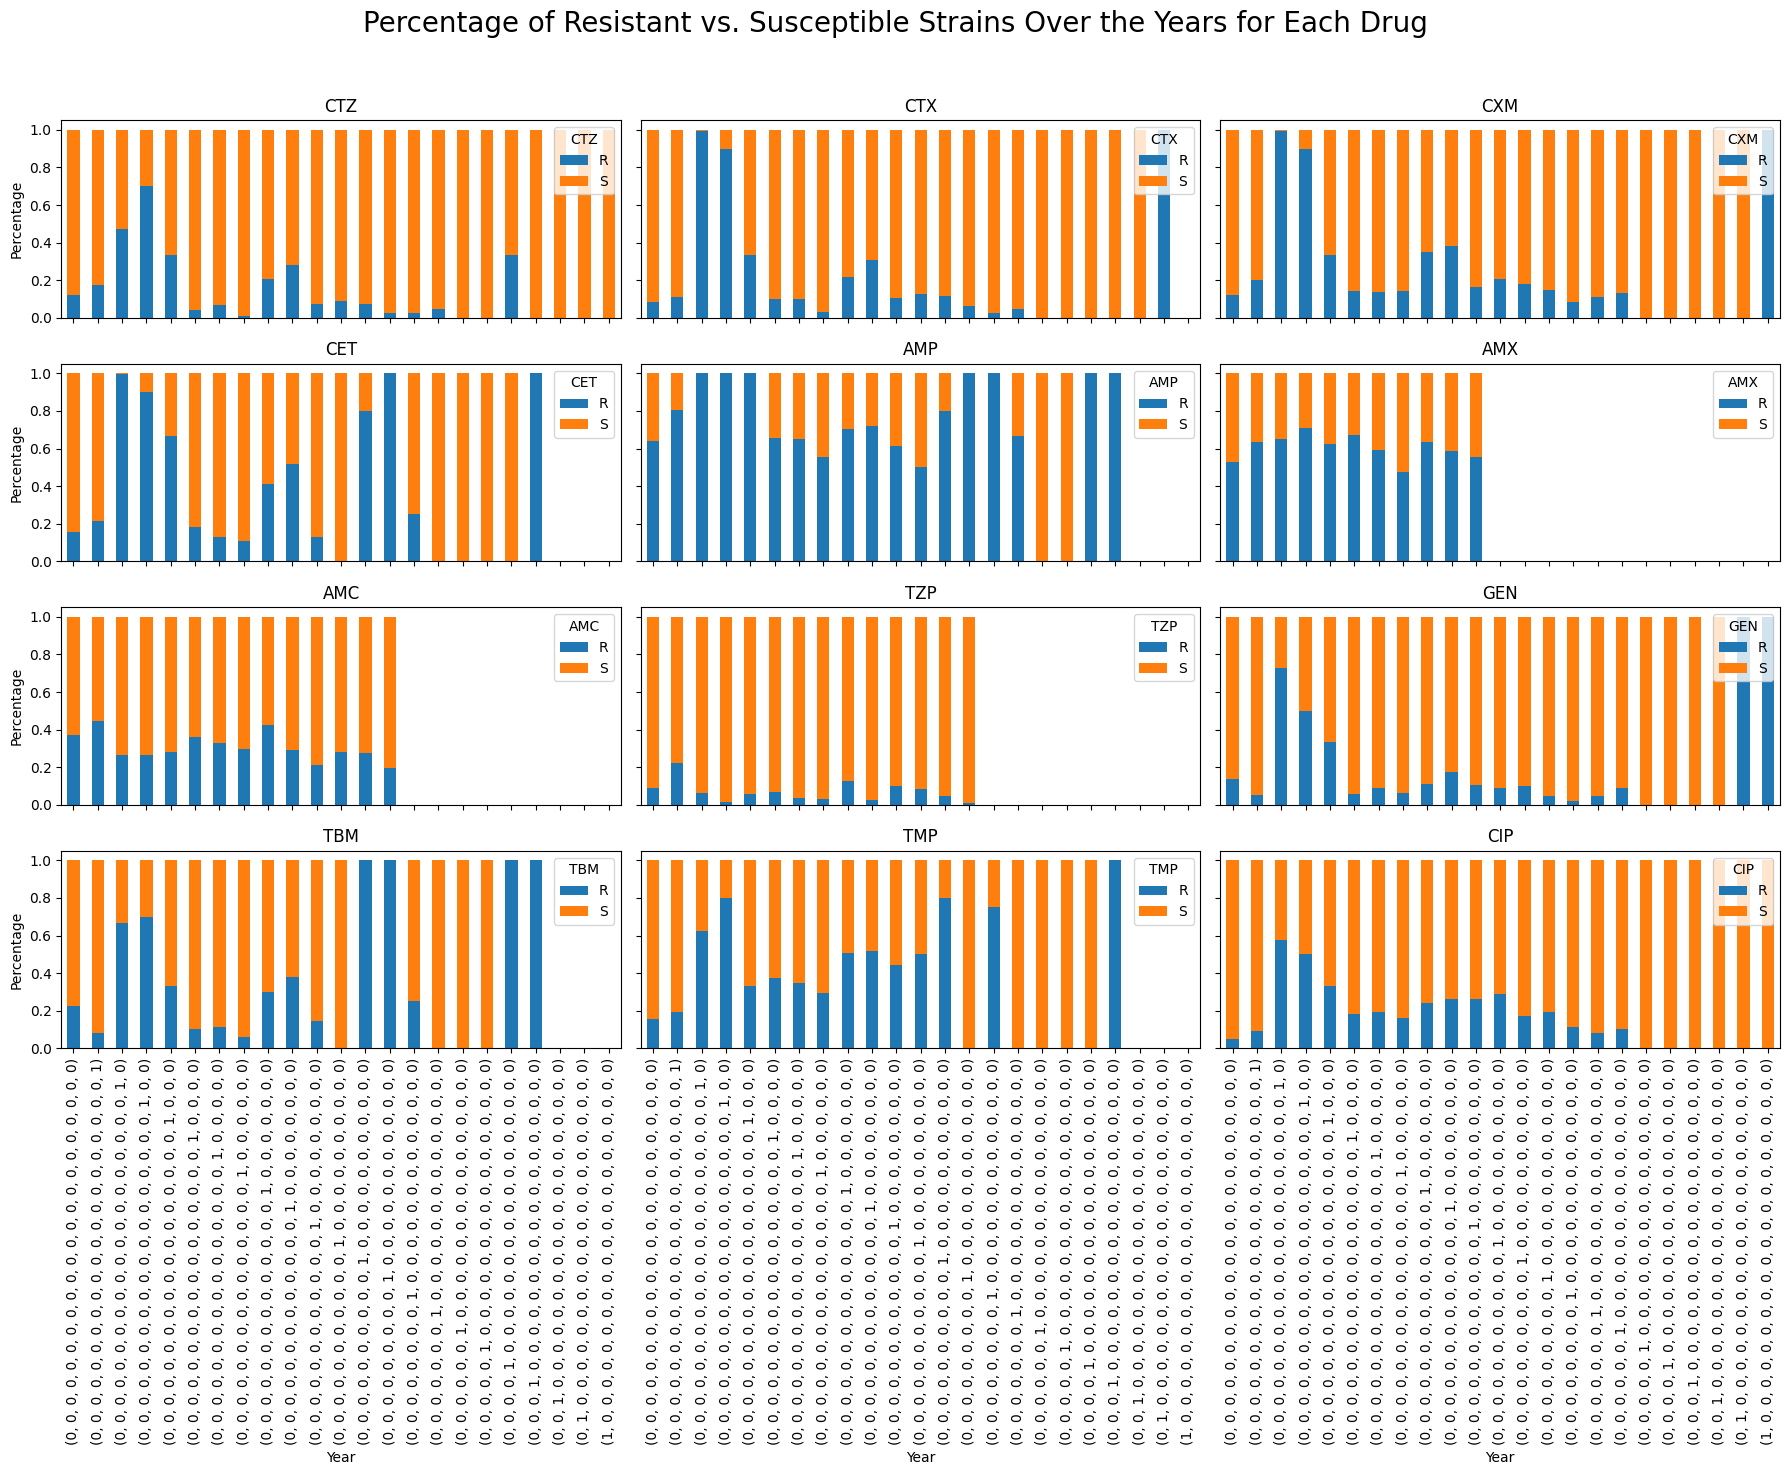

In [31]:
drug_labels = ['CTZ', 'CTX', 'CXM', 'CET', 'AMP', 'AMX', 'AMC', 'TZP', 'GEN', 'TBM', 'TMP', 'CIP']
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 15), sharex=True, sharey=True)
fig.suptitle('Percentage of Resistant vs. Susceptible Strains Over the Years for Each Drug', fontsize=20)

for i, drug in enumerate(drug_labels):
    row, col = divmod(i, 3)

    year_columns = [col for col in metadata_d.columns if col.startswith('Year_')]
    yearly_resistance = metadata_d.groupby(year_columns)[drug].value_counts(normalize=True).unstack().fillna(0)

    yearly_resistance.plot(kind='bar', stacked=True, ax=axes[row, col])
    axes[row, col].set_title(drug)
    axes[row, col].set_ylabel('Percentage')
    axes[row, col].set_xlabel('Year')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## Task 2: visualize the clustering of the strains.
Using The Population Structure Dataframe, create 4 different pie charts for the following cutoff values: **cutoff_823, cutoff_6934, cutoff_9768,[link text](https://) cutoff_11227**. Write what you notice as cutoff_values increase.

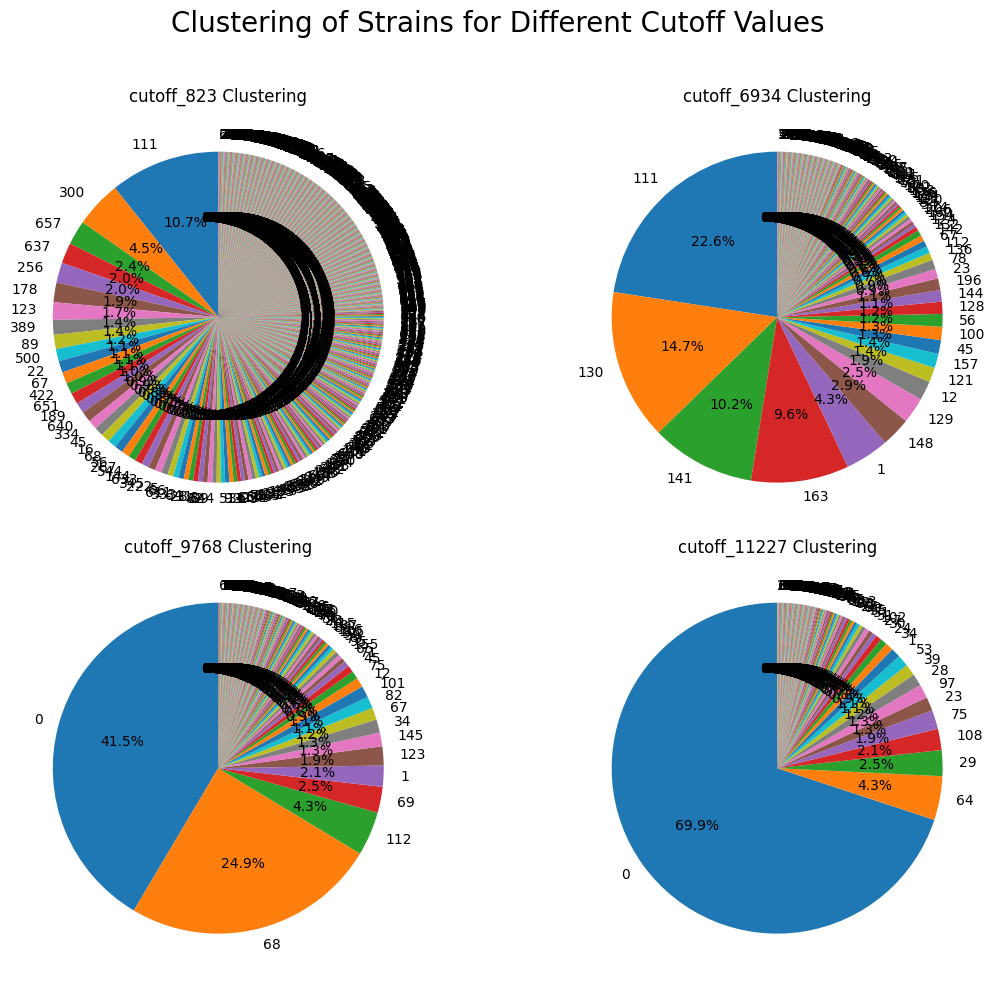

In [27]:
cutoff_values = ['cutoff_823', 'cutoff_6934', 'cutoff_9768', 'cutoff_11227']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle('Clustering of Strains for Different Cutoff Values', fontsize=20)

for i, cutoff in enumerate(cutoff_values):
    row, col = divmod(i, 2)

    cluster_counts = pop_struc_data[cutoff].value_counts()
    axes[row, col].pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', startangle=90)
    axes[row, col].set_title(f'{cutoff} Clustering')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


THANKS for making it this far! Now that our data is ready the next notebooks will deal with the creation and training of different algorithms using the dataframe we just created in this notebook!!!